# Novelty on data preprocessing

**Novelty created by:** Yichen Shi, Jingyu Wang <br>
**Summary:**  We try to fill the missing values in each features using KNN imputation as well as mean values. We select features based on the new correlation matrix. We test the new processed data on some classifers.

## Load packagaes

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings 
from sklearn.svm import SVC, NuSVC
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from lightgbm import  LGBMClassifier
from sklearn.ensemble import VotingClassifier
from numpy import isnan
from sklearn.impute import KNNImputer
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

## 1.  Filling missing value with knn imputation 
There are many missing values represented as 0 in many features such as Glucose, blood pressure, skinthickness and so on. Our parent paper replace these values with mean, here, we use the knn method to filling the values. <br>
Our parent paper find the mean value of each feature by grouping by the outcome value. Therefore, we apply fiiling knn clustering on outcome = 0 and outcome =1 respectively, for the column with missing values. 

In [2]:
# inspect the data
data = pd.read_csv('diabetes.csv')
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# filling the missing values on outcome =1
# convert the 0 values to NA
for col in [ 'Glucose','BloodPressure','BMI']:  
    data.loc[(data[col] == 0) & (data['Outcome']==1),col] = np.NaN

In [4]:
data.isnull().any()

Pregnancies                 False
Glucose                      True
BloodPressure                True
SkinThickness               False
Insulin                     False
BMI                          True
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [5]:
x = data[[ 'Glucose','BloodPressure','BMI']]
y = data['Outcome']
print('Missing: %d' % sum(isnan(x).values.flatten()))

Missing: 20


In [7]:
# find the optimal k using pipeline
results = list()
strategies = [str(i) for i in [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

>1 0.721 (0.049)
>3 0.723 (0.045)
>5 0.722 (0.051)
>7 0.726 (0.049)
>9 0.722 (0.047)
>11 0.723 (0.045)
>13 0.731 (0.045)
>15 0.729 (0.045)
>17 0.717 (0.047)
>19 0.722 (0.049)
>21 0.726 (0.049)
>23 0.721 (0.041)
>25 0.728 (0.049)
>27 0.728 (0.044)
>29 0.724 (0.046)
>31 0.725 (0.046)
>33 0.726 (0.046)
>35 0.725 (0.043)
>37 0.720 (0.046)
>39 0.723 (0.052)
>41 0.724 (0.045)
>43 0.723 (0.049)
>45 0.725 (0.048)
>47 0.727 (0.044)
>49 0.722 (0.047)


In [6]:
imputer = KNNImputer(n_neighbors= 35, weights='uniform', metric='nan_euclidean')
imputer.fit(x)
Xtrans = imputer.transform(x)
print('Missing: %d' % sum(isnan(Xtrans).flatten()))

Missing: 0


In [7]:
data[[ 'Glucose','BloodPressure','BMI']] = Xtrans

In [8]:
# filling the missing values on outcome =0
# convert the 0 values to NA
for col in [ 'Glucose','BloodPressure','BMI']:  
    data.loc[(data[col] == 0) & (data['Outcome']==0),col] = np.NaN

In [9]:
x = data[[ 'Glucose','BloodPressure','BMI']]
y = data['Outcome']
print('Missing: %d' % sum(isnan(x).values.flatten()))

Missing: 31


In [12]:
# find the optimal k using pipeline
results = list()
strategies = [str(i) for i in [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

>1 0.714 (0.047)
>3 0.720 (0.043)
>5 0.722 (0.042)
>7 0.724 (0.047)
>9 0.724 (0.049)
>11 0.722 (0.046)
>13 0.715 (0.045)
>15 0.722 (0.047)
>17 0.721 (0.050)
>19 0.721 (0.051)
>21 0.723 (0.049)
>23 0.720 (0.047)
>25 0.720 (0.053)
>27 0.720 (0.048)
>29 0.724 (0.049)
>31 0.726 (0.046)
>33 0.730 (0.050)
>35 0.730 (0.045)
>37 0.725 (0.052)
>39 0.727 (0.046)
>41 0.723 (0.047)
>43 0.722 (0.051)
>45 0.721 (0.051)
>47 0.720 (0.051)
>49 0.719 (0.053)


In [10]:
imputer = KNNImputer(n_neighbors= 39, weights='uniform', metric='nan_euclidean')
imputer.fit(x)
Xtrans = imputer.transform(x)
print('Missing: %d' % sum(isnan(Xtrans).flatten()))

Missing: 0


In [11]:
data[[ 'Glucose','BloodPressure','BMI']] = Xtrans

In [12]:
data.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [13]:
# for some features, we found filling missing values with mean works better
field = 'Insulin'
target = 'Outcome'
mean_by_target = data.loc[data[field] != 0, [field, target]].groupby(target).mean()
data.loc[(data[field] == 0)&(data[target] == 0), field] = mean_by_target.iloc[0][0]
data.loc[(data[field] == 0)&(data[target] == 1), field] = mean_by_target.iloc[1][0]


field = 'SkinThickness'
target = 'Outcome'
mean_by_target = data.loc[data[field] != 0, [field, target]].groupby(target).mean()
data.loc[(data[field] == 0)&(data[target] == 0), field] = mean_by_target.iloc[0][0]
data.loc[(data[field] == 0)&(data[target] == 1), field] = mean_by_target.iloc[1][0]

## Define utility functions for data plots & evaluation graph

In [6]:
Renamed_feature= []              
all_clf_res=[]                    
random_initializer=100            
n_dots=50


for i in range(8):
    Renamed_feature.append('F'+str(i+1)) 



def plot_confusionMatrix(data):
    sns.set(font_scale=1.15)                                    
    ax = plt.figure(figsize=(10, 8))                           
    plt.title("Confusion Matrix of all features")
    sns.heatmap(data.corr(),                                   
                  vmax=1.0,                                                                                   
                  vmin=0.0,
                  linewidths=0.01,
                  square=False,                                  
                  annot=True,                                     
                  linecolor="black")
    b, t = plt.ylim()                                          
    b += 0.5
    t -= 0.5 
    plt.ylim(b, t) 
    plt.show() 



def dist_Plot(data):
    fig, ax = plt.subplots(2,4, figsize=(12,5))
    sns.set()
    sns.distplot(data.F1, bins = 10, ax=ax[0,0])
    sns.distplot(data.F2, bins = 10, ax=ax[0,1]) 
    sns.distplot(data.F3, bins = 10, ax=ax[0,2]) 
    sns.distplot(data.F4, bins = 10, ax=ax[0,3])
    sns.distplot(data.F5, bins = 10, ax=ax[1,0]) 
    sns.distplot(data.F6, bins = 10, ax=ax[1,1]) 
    sns.distplot(data.F7, bins = 10, ax=ax[1,2]) 
    sns.distplot(data.F8, bins = 10, ax=ax[1,3]) 
    fig.suptitle("Gaussian Distribution of all features")
    fig.tight_layout() 
    
                                                              
                                                        

def IQR (data):
    for i in range(8):
        Q1 = data[Renamed_feature[i]].quantile(0.25)
        Q3 = data[Renamed_feature[i]].quantile(0.75)
        IQR = Q3-Q1 
        LW = (Q1 - 1.5 * IQR)
        UW = (Q3 + 1.5 * IQR)
        data = data[data[Renamed_feature[i]]<UW]
        data = data[data[Renamed_feature[i]]>LW] 
    return data

    
# outlier rejection using IQR method
def outlier_Rejection (data):
    data = IQR (data)
    return data


def data_plot (data,
               Dist_Plot,
               Plot_confusionMatrix):
    dist_Plot(data)
    plot_confusionMatrix(data)


def metrics (y_true, y_pred, probas_):
    points=n_dots*'-'
    print(points)
    fpr, tpr, thresholds = roc_curve(y_true, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    print("Detailed classification report for current fold:")
    print()
    print(classification_report(y_true, y_pred))
    print()
    print("Area Under ROC (AUC): {}".format(roc_auc))
    print()
    print('Confusion Matrix for current fold: ')
    print(confusion_matrix(y_true, y_pred))
    print()
    print("Accuracy for Current Fold: {}".format(accuracy_score(y_true, y_pred)))
    print()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return  tn, fp, fn, tp, roc_auc, fpr, tpr


def average_ROC(mean_fpr,tprs,aucs,TP,TN,FP,FN):
    sen = (np.sum(TP))/(np.sum(TP)+np.sum(FN))
    spe = (np.sum(TN))/(np.sum(TN)+np.sum(FP))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ax = plt.axes()
    ax.grid(color='lightgray', linestyle='-', linewidth=.5)
    ax.set_facecolor("white")
    ax.spines['bottom'].set_color('#000000')
    ax.spines['top'].set_color('#000000') 
    ax.spines['right'].set_color('#000000')
    ax.spines['left'].set_color('#000000')
    plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Avg. ROC (AUC (avg $\pm$ std) = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)
    plt.scatter((1-spe), sen, s=80, c='r', marker='x',)
    plt.scatter(0, sen, s=80, c='r', marker='x',)
    plt.scatter((1-spe),0, s=80, c='r', marker='x',)
    plt.axhline(y=sen, color='r', linestyle='--')
    plt.axvline(x=(1-spe), color='r', linestyle='--')
    plt.text((1-spe), 0.02, "FPR={:0.3f}".format((1-spe)))
    plt.text(0.009, sen+0.05, "TPR={:0.3f}".format(sen))
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='darkgray', alpha=0.5,
                  label=r'$\pm$ 1 Standard deviation')
    plt.xticks(np.arange(0.0, 1.01, step=0.1))
    plt.yticks(np.arange(0.0, 1.01, step=0.1))
    left=0.0
    right=1.0
    plt.xlim(left, right)
    plt.ylim(left, right)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc="lower right")
    plt.show()



def plot_Current_ROC(fpr,tpr,iterator,roc_auc):
    plt.plot(fpr,
             tpr,
             alpha=0.35,
             linewidth=1)
   


   
# create ml models
def creat_Model (classifier, X_Train, Y_Train, tuned_parameters, verbose):
    clf = GridSearchCV(classifier,
                    tuned_parameters,
                    verbose=verbose,
                    cv=5,
                    scoring='roc_auc',
                    n_jobs=-1)
    clf.fit(X_Train, Y_Train)
    return clf


def average_performance(aucs,Accuracy,TP,TN,FP,FN): 
    print()
    n_dotsav=(n_dots-len('Average'))//2
    print('-'*n_dotsav+'Average'+'-'*n_dotsav)
    print("AUC (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(aucs),np.std(aucs)))
    print("Accuracy (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(Accuracy),np.std(Accuracy)))
    cm = [[int(np.mean(TP)), int(np.mean(FP))],[int(np.mean(FN)), int(np.mean(TN))]]
    print ('Avg. CM is '+str(cm))
    cm = [[int(np.sum(TP)), int(np.sum(FP))],[int(np.sum(FN)), int(np.sum(TN))]]
    print ('Total for all folds CM is '+str(cm))
    re_auc=str(round(np.mean(aucs), 3))+'+/-'+str(round(np.std(aucs),3))
    all_clf_res.append(re_auc)
    

# feature selection function
def feature_Selector(data, algo, n_feature):
    if algo =='corr':
        if n_feature ==4:
            data = data[['F2','F5','F4','F6','Outcome']]                
            return data.iloc[:,:4].values, data.iloc[:,4:].values
        if n_feature ==6:
            data = data[['F1','F2','F4','F5','F6','F8','Outcome']]       
            return data.iloc[:,:6].values, data.iloc[:,6:].values
        
    if algo == 'None':
        return data.iloc[:,:8].values, data.iloc[:,8:].values           



In [5]:
data = pd.DataFrame({'F1':data.iloc[:,:8].values[:,0],
                     'F2':data.iloc[:,:8].values[:,1],
                     'F3':data.iloc[:,:8].values[:,2],
                     'F4':data.iloc[:,:8].values[:,3],
                     'F5':data.iloc[:,:8].values[:,4],
                     'F6':data.iloc[:,:8].values[:,5],
                     'F7':data.iloc[:,:8].values[:,6],
                     'F8':data.iloc[:,:8].values[:,7],
                     'Outcome':data.iloc[:,8:].values[:,0]})

## 2. Outlier Rejection

In [ ]:
print('Shape Before Process: ' + str(data.shape))
data = outlier_Rejection (data)
print('Shape After outlier Removed: ' + str(data.shape))

In [23]:
# save the processed data
data.to_csv('processed_data2.csv', index=False)

## Processed Data Plot 
After filling missing values and outlier rejection, we can see from the below distribution that they are less skewed. Also, from the confusion matrix, F5 and F4 are improved compared to the parent paper.

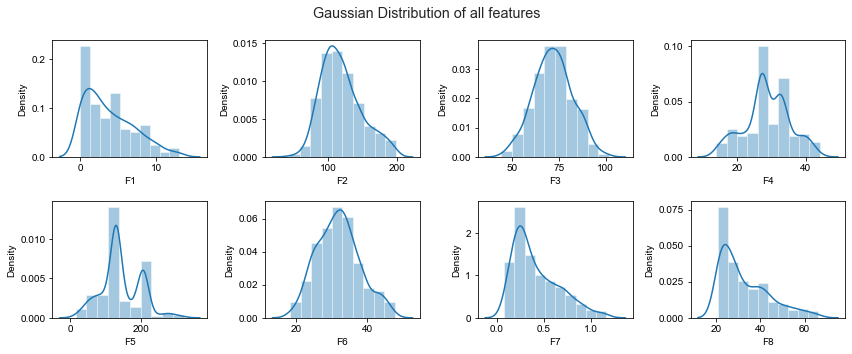

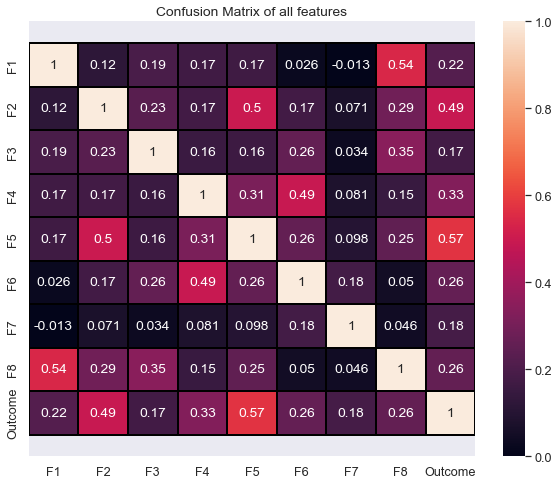

In [21]:
data_plot (data,
          Pair_plot=False,
          Dist_Plot=True,
          Plot_violinplot=False,
          Plot_confusionMatrix=True,
          box_Gaussian=False)

## 3. Feature selection based on correlation

In [18]:
X_Data,Y_Lavel = feature_Selector(data, algo='corr', n_feature=6)    
print('Shape After Feature Selection: ' + str(data.shape))

kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=random_initializer)

Shape After Feature Selection: (607, 9)


## Testing the new processed data using ensemble method

In [20]:
def Ensembler(n_model, X_Train, Y_Train, X_Test, Y_Test, weight):
   
    
    # lgbm
    tuned_parameters = {"learning_rate": [0.01, 0.05, 0.1],
              "n_estimators": [200, 500, 1000],
              "max_depth":[5,8,10],
              "colsample_bytree": [1,0.5,0.3]}
    
    clf_lgbm = creat_Model (classifier = LGBMClassifier(random_state=42),
                      X_Train = X_Train,                                    
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    
 
    # adaboost
    tuned_parameters_ab = { 'algorithm': ['SAMME','SAMME.R'],         
                   'learning_rate':[0.1,0.5,1.0],
                   'n_estimators': [10,50,100,200]}

    clf_ab = creat_Model (classifier = AdaBoostClassifier(random_state=random_initializer),
                  X_Train = X_Train,                                
                  Y_Train = Y_Train,
                  tuned_parameters = tuned_parameters_ab,
                  verbose=0)
 
   
    # xgboost
    tuned_parameters_xb = {                                          
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

        
    clf_xb = creat_Model (classifier = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'error',random_state=random_initializer,
                                                use_label_encoder=False ),
                      X_Train = X_Train,                             
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_xb,
                      verbose=0)
    
    
    if weight == 'None':                                             
        if n_model == 1:                                              
            model = VotingClassifier([('ab', clf_ab), 
                                      ('xb', clf_xb)], 
                                     voting='soft')
            model.fit(X_Train,Y_Train)
            return model 
       
        
        if n_model == 2:
            model = VotingClassifier([('xb', clf_xb),
                                      ('lgbm',clf_lgbm)], 
                                     voting='soft',
                                     weights=[accuracy_score(Y_Test, clf_xb.predict(X_Test)),
                                              accuracy_score(Y_Test, clf_lgbm.predict(X_Test))])
            model.fit(X_Train,Y_Train)
            return model



### Analyzing  XB + AB

Learning rate set to 0.020742
0:	learn: 0.6718162	total: 59.7ms	remaining: 17.8s
1:	learn: 0.6498463	total: 61.9ms	remaining: 9.22s
2:	learn: 0.6338052	total: 63.9ms	remaining: 6.33s
3:	learn: 0.6197729	total: 65.5ms	remaining: 4.85s
4:	learn: 0.6060834	total: 67ms	remaining: 3.95s
5:	learn: 0.5921917	total: 68.3ms	remaining: 3.35s
6:	learn: 0.5777069	total: 69.3ms	remaining: 2.9s
7:	learn: 0.5632235	total: 70.3ms	remaining: 2.57s
8:	learn: 0.5519222	total: 71.3ms	remaining: 2.3s
9:	learn: 0.5412279	total: 72.2ms	remaining: 2.09s
10:	learn: 0.5301828	total: 73.2ms	remaining: 1.92s
11:	learn: 0.5180125	total: 74.1ms	remaining: 1.78s
12:	learn: 0.5069717	total: 75.1ms	remaining: 1.66s
13:	learn: 0.4965018	total: 76ms	remaining: 1.55s
14:	learn: 0.4877383	total: 77ms	remaining: 1.46s
15:	learn: 0.4776100	total: 77.9ms	remaining: 1.38s
16:	learn: 0.4691460	total: 78.9ms	remaining: 1.31s
17:	learn: 0.4617559	total: 79.5ms	remaining: 1.25s
18:	learn: 0.4544758	total: 80.1ms	remaining: 1.18s


Learning rate set to 0.022815
0:	learn: 0.6733533	total: 55.9ms	remaining: 16.7s
1:	learn: 0.6497345	total: 57.8ms	remaining: 8.61s
2:	learn: 0.6301004	total: 59.5ms	remaining: 5.89s
3:	learn: 0.6166519	total: 61ms	remaining: 4.51s
4:	learn: 0.6002938	total: 62.6ms	remaining: 3.69s
5:	learn: 0.5863348	total: 63.9ms	remaining: 3.13s
6:	learn: 0.5719994	total: 65.1ms	remaining: 2.72s
7:	learn: 0.5572250	total: 66.5ms	remaining: 2.42s
8:	learn: 0.5426176	total: 67.5ms	remaining: 2.18s
9:	learn: 0.5285413	total: 68.2ms	remaining: 1.98s
10:	learn: 0.5178562	total: 69.2ms	remaining: 1.82s
11:	learn: 0.5046699	total: 70.1ms	remaining: 1.68s
12:	learn: 0.4944591	total: 71.1ms	remaining: 1.57s
13:	learn: 0.4843256	total: 72.1ms	remaining: 1.47s
14:	learn: 0.4767475	total: 73ms	remaining: 1.39s
15:	learn: 0.4671416	total: 74ms	remaining: 1.31s
16:	learn: 0.4582784	total: 74.9ms	remaining: 1.25s
17:	learn: 0.4508742	total: 75.9ms	remaining: 1.19s
18:	learn: 0.4428733	total: 76.8ms	remaining: 1.14

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        82
           1       0.81      0.75      0.78        40

    accuracy                           0.86       122
   macro avg       0.85      0.83      0.84       122
weighted avg       0.86      0.86      0.86       122


Area Under ROC (AUC): 0.9448170731707316

Confusion Matrix for current fold: 
[[75  7]
 [10 30]]

Accuracy for Current Fold: 0.860655737704918

Learning rate set to 0.020742
0:	learn: 0.6747875	total: 59.5ms	remaining: 17.8s
1:	learn: 0.6541445	total: 61.9ms	remaining: 9.22s
2:	learn: 0.6373988	total: 64ms	remaining: 6.33s
3:	learn: 0.6243698	total: 65.6ms	remaining: 4.86s
4:	learn: 0.6090925	total: 67.1ms	remaining: 3.96s
5:	learn: 0.5960549	total: 68.4ms	remaining: 3.35s
6:	learn: 0.5809462	total: 69.5ms	remaining: 2.91s
7:	learn: 0.5653943	total: 70.4ms	remainin

174:	learn: 0.2162793	total: 130ms	remaining: 93ms
175:	learn: 0.2161958	total: 131ms	remaining: 92.5ms
176:	learn: 0.2159130	total: 132ms	remaining: 91.8ms
177:	learn: 0.2154496	total: 133ms	remaining: 91.1ms
178:	learn: 0.2153674	total: 134ms	remaining: 90.4ms
179:	learn: 0.2150532	total: 134ms	remaining: 89.6ms
180:	learn: 0.2143329	total: 135ms	remaining: 88.8ms
181:	learn: 0.2142528	total: 136ms	remaining: 87.9ms
182:	learn: 0.2138359	total: 136ms	remaining: 87.1ms
183:	learn: 0.2136124	total: 137ms	remaining: 86.3ms
184:	learn: 0.2131477	total: 138ms	remaining: 85.7ms
185:	learn: 0.2126180	total: 139ms	remaining: 85ms
186:	learn: 0.2123806	total: 139ms	remaining: 84.2ms
187:	learn: 0.2120924	total: 140ms	remaining: 83.4ms
188:	learn: 0.2108628	total: 141ms	remaining: 82.6ms
189:	learn: 0.2107636	total: 141ms	remaining: 81.9ms
190:	learn: 0.2099312	total: 142ms	remaining: 81.1ms
191:	learn: 0.2094371	total: 143ms	remaining: 80.3ms
192:	learn: 0.2088654	total: 143ms	remaining: 79.5

30:	learn: 0.4039770	total: 39.7ms	remaining: 345ms
31:	learn: 0.3998833	total: 40.9ms	remaining: 342ms
32:	learn: 0.3951273	total: 41.9ms	remaining: 339ms
33:	learn: 0.3904638	total: 42.9ms	remaining: 335ms
34:	learn: 0.3863179	total: 43.8ms	remaining: 332ms
35:	learn: 0.3835572	total: 44.9ms	remaining: 330ms
36:	learn: 0.3790827	total: 46ms	remaining: 327ms
37:	learn: 0.3753336	total: 46.9ms	remaining: 324ms
38:	learn: 0.3708412	total: 48ms	remaining: 321ms
39:	learn: 0.3676592	total: 49ms	remaining: 318ms
40:	learn: 0.3647821	total: 50.2ms	remaining: 317ms
41:	learn: 0.3616792	total: 53.4ms	remaining: 328ms
42:	learn: 0.3592867	total: 54.4ms	remaining: 325ms
43:	learn: 0.3552152	total: 55.4ms	remaining: 323ms
44:	learn: 0.3519708	total: 56.4ms	remaining: 320ms
45:	learn: 0.3462667	total: 57.4ms	remaining: 317ms
46:	learn: 0.3436990	total: 58.5ms	remaining: 315ms
47:	learn: 0.3418118	total: 59.5ms	remaining: 312ms
48:	learn: 0.3393866	total: 60.5ms	remaining: 310ms
49:	learn: 0.33745

Learning rate set to 0.022815
0:	learn: 0.6753329	total: 808us	remaining: 242ms
1:	learn: 0.6552214	total: 1.62ms	remaining: 241ms
2:	learn: 0.6398769	total: 2.46ms	remaining: 243ms
3:	learn: 0.6267664	total: 3.35ms	remaining: 248ms
4:	learn: 0.6121984	total: 4.15ms	remaining: 245ms
5:	learn: 0.5990959	total: 4.97ms	remaining: 243ms
6:	learn: 0.5864323	total: 5.78ms	remaining: 242ms
7:	learn: 0.5729267	total: 6.66ms	remaining: 243ms
8:	learn: 0.5611530	total: 7.8ms	remaining: 252ms
9:	learn: 0.5502856	total: 8.85ms	remaining: 257ms
10:	learn: 0.5387355	total: 9.89ms	remaining: 260ms
11:	learn: 0.5281893	total: 11ms	remaining: 264ms
12:	learn: 0.5189321	total: 12.1ms	remaining: 266ms
13:	learn: 0.5097229	total: 13.1ms	remaining: 267ms
14:	learn: 0.4999669	total: 14ms	remaining: 266ms
15:	learn: 0.4895516	total: 14.9ms	remaining: 265ms
16:	learn: 0.4818433	total: 15.9ms	remaining: 264ms
17:	learn: 0.4742256	total: 16.8ms	remaining: 263ms
18:	learn: 0.4656221	total: 17.7ms	remaining: 262m

181:	learn: 0.2259305	total: 168ms	remaining: 109ms
182:	learn: 0.2254643	total: 169ms	remaining: 108ms
183:	learn: 0.2251405	total: 170ms	remaining: 107ms
184:	learn: 0.2243650	total: 171ms	remaining: 106ms
185:	learn: 0.2242151	total: 172ms	remaining: 106ms
186:	learn: 0.2238683	total: 173ms	remaining: 105ms
187:	learn: 0.2236706	total: 174ms	remaining: 104ms
188:	learn: 0.2232996	total: 175ms	remaining: 103ms
189:	learn: 0.2230066	total: 176ms	remaining: 102ms
190:	learn: 0.2221900	total: 177ms	remaining: 101ms
191:	learn: 0.2216382	total: 178ms	remaining: 99.9ms
192:	learn: 0.2203282	total: 179ms	remaining: 99ms
193:	learn: 0.2199992	total: 179ms	remaining: 98.1ms
194:	learn: 0.2196026	total: 180ms	remaining: 97.1ms
195:	learn: 0.2191348	total: 181ms	remaining: 96.2ms
196:	learn: 0.2189652	total: 182ms	remaining: 95.2ms
197:	learn: 0.2187071	total: 183ms	remaining: 94.3ms
198:	learn: 0.2177295	total: 184ms	remaining: 93.3ms
199:	learn: 0.2173663	total: 185ms	remaining: 92.4ms
200:	

266:	learn: 0.1948660	total: 369ms	remaining: 45.6ms
267:	learn: 0.1945158	total: 370ms	remaining: 44.1ms
268:	learn: 0.1943379	total: 371ms	remaining: 42.7ms
269:	learn: 0.1939660	total: 372ms	remaining: 41.3ms
270:	learn: 0.1937970	total: 373ms	remaining: 39.9ms
271:	learn: 0.1935663	total: 374ms	remaining: 38.5ms
272:	learn: 0.1933405	total: 375ms	remaining: 37.1ms
273:	learn: 0.1920485	total: 376ms	remaining: 35.7ms
274:	learn: 0.1917600	total: 378ms	remaining: 34.3ms
275:	learn: 0.1913952	total: 379ms	remaining: 32.9ms
276:	learn: 0.1899287	total: 380ms	remaining: 31.5ms
277:	learn: 0.1897978	total: 381ms	remaining: 30.1ms
278:	learn: 0.1894298	total: 382ms	remaining: 28.8ms
279:	learn: 0.1893441	total: 383ms	remaining: 27.4ms
280:	learn: 0.1891929	total: 385ms	remaining: 26ms
281:	learn: 0.1885823	total: 386ms	remaining: 24.7ms
282:	learn: 0.1879785	total: 388ms	remaining: 23.3ms
283:	learn: 0.1874455	total: 389ms	remaining: 21.9ms
284:	learn: 0.1872863	total: 390ms	remaining: 20

32:	learn: 0.3828664	total: 36.6ms	remaining: 296ms
33:	learn: 0.3780984	total: 39.7ms	remaining: 311ms
34:	learn: 0.3735634	total: 40.8ms	remaining: 309ms
35:	learn: 0.3702849	total: 41.8ms	remaining: 306ms
36:	learn: 0.3660780	total: 42.8ms	remaining: 304ms
37:	learn: 0.3614569	total: 43.8ms	remaining: 302ms
38:	learn: 0.3554251	total: 45.1ms	remaining: 302ms
39:	learn: 0.3519752	total: 46.1ms	remaining: 300ms
40:	learn: 0.3491465	total: 47.1ms	remaining: 297ms
41:	learn: 0.3453330	total: 48.1ms	remaining: 295ms
42:	learn: 0.3422373	total: 49ms	remaining: 293ms
43:	learn: 0.3388644	total: 50ms	remaining: 291ms
44:	learn: 0.3366528	total: 51ms	remaining: 289ms
45:	learn: 0.3342968	total: 52ms	remaining: 287ms
46:	learn: 0.3294912	total: 53ms	remaining: 286ms
47:	learn: 0.3267981	total: 54ms	remaining: 284ms
48:	learn: 0.3240539	total: 55ms	remaining: 282ms
49:	learn: 0.3217255	total: 56ms	remaining: 280ms
50:	learn: 0.3192525	total: 57ms	remaining: 278ms
51:	learn: 0.3173929	total: 58

Learning rate set to 0.022835
0:	learn: 0.6728124	total: 938us	remaining: 281ms
1:	learn: 0.6534288	total: 1.83ms	remaining: 273ms
2:	learn: 0.6345235	total: 2.75ms	remaining: 273ms
3:	learn: 0.6182652	total: 3.68ms	remaining: 272ms
4:	learn: 0.6023827	total: 4.63ms	remaining: 273ms
5:	learn: 0.5887968	total: 5.53ms	remaining: 271ms
6:	learn: 0.5756622	total: 6.41ms	remaining: 268ms
7:	learn: 0.5614545	total: 7.36ms	remaining: 269ms
8:	learn: 0.5484186	total: 8.28ms	remaining: 268ms
9:	learn: 0.5360224	total: 9.13ms	remaining: 265ms
10:	learn: 0.5236691	total: 10.1ms	remaining: 264ms
11:	learn: 0.5125785	total: 11ms	remaining: 263ms
12:	learn: 0.5026758	total: 11.9ms	remaining: 264ms
13:	learn: 0.4928018	total: 12.9ms	remaining: 263ms
14:	learn: 0.4830386	total: 13.7ms	remaining: 261ms
15:	learn: 0.4723016	total: 14.6ms	remaining: 259ms
16:	learn: 0.4634928	total: 15.5ms	remaining: 259ms
17:	learn: 0.4549197	total: 16.4ms	remaining: 258ms
18:	learn: 0.4469008	total: 17.4ms	remaining: 2

184:	learn: 0.2082847	total: 168ms	remaining: 104ms
185:	learn: 0.2080005	total: 169ms	remaining: 104ms
186:	learn: 0.2077675	total: 170ms	remaining: 103ms
187:	learn: 0.2074331	total: 171ms	remaining: 102ms
188:	learn: 0.2063982	total: 172ms	remaining: 101ms
189:	learn: 0.2058745	total: 173ms	remaining: 100ms
190:	learn: 0.2056867	total: 174ms	remaining: 99.4ms
191:	learn: 0.2054248	total: 175ms	remaining: 98.4ms
192:	learn: 0.2051571	total: 176ms	remaining: 97.5ms
193:	learn: 0.2050079	total: 177ms	remaining: 96.6ms
194:	learn: 0.2048241	total: 178ms	remaining: 95.7ms
195:	learn: 0.2044782	total: 179ms	remaining: 94.8ms
196:	learn: 0.2041446	total: 180ms	remaining: 93.9ms
197:	learn: 0.2038270	total: 180ms	remaining: 92.9ms
198:	learn: 0.2034466	total: 181ms	remaining: 92ms
199:	learn: 0.2032392	total: 182ms	remaining: 91ms
200:	learn: 0.2023476	total: 183ms	remaining: 90.1ms
201:	learn: 0.2021843	total: 184ms	remaining: 89.2ms
202:	learn: 0.2019938	total: 185ms	remaining: 88.3ms
203

242:	learn: 0.1886827	total: 181ms	remaining: 42.4ms
243:	learn: 0.1884221	total: 181ms	remaining: 41.6ms
244:	learn: 0.1882612	total: 182ms	remaining: 40.9ms
245:	learn: 0.1880921	total: 183ms	remaining: 40.1ms
246:	learn: 0.1879345	total: 183ms	remaining: 39.3ms
247:	learn: 0.1875114	total: 184ms	remaining: 38.6ms
248:	learn: 0.1871803	total: 185ms	remaining: 37.8ms
249:	learn: 0.1866575	total: 185ms	remaining: 37ms
250:	learn: 0.1862958	total: 186ms	remaining: 36.3ms
251:	learn: 0.1859682	total: 186ms	remaining: 35.5ms
252:	learn: 0.1857876	total: 187ms	remaining: 34.7ms
253:	learn: 0.1856855	total: 188ms	remaining: 34ms
254:	learn: 0.1853765	total: 189ms	remaining: 33.3ms
255:	learn: 0.1851001	total: 189ms	remaining: 32.5ms
256:	learn: 0.1849164	total: 190ms	remaining: 31.8ms
257:	learn: 0.1847003	total: 190ms	remaining: 31ms
258:	learn: 0.1844609	total: 191ms	remaining: 30.2ms
259:	learn: 0.1842617	total: 192ms	remaining: 29.5ms
260:	learn: 0.1839234	total: 193ms	remaining: 28.8ms

76:	learn: 0.2830031	total: 81.4ms	remaining: 236ms
77:	learn: 0.2813766	total: 82.3ms	remaining: 234ms
78:	learn: 0.2800418	total: 83.3ms	remaining: 233ms
79:	learn: 0.2783511	total: 84.3ms	remaining: 232ms
80:	learn: 0.2776392	total: 85.3ms	remaining: 231ms
81:	learn: 0.2768912	total: 86.4ms	remaining: 230ms
82:	learn: 0.2758504	total: 87.4ms	remaining: 229ms
83:	learn: 0.2742418	total: 88.5ms	remaining: 227ms
84:	learn: 0.2731645	total: 89.5ms	remaining: 226ms
85:	learn: 0.2725479	total: 90.4ms	remaining: 225ms
86:	learn: 0.2721293	total: 91.4ms	remaining: 224ms
87:	learn: 0.2713397	total: 92.4ms	remaining: 223ms
88:	learn: 0.2703733	total: 93.4ms	remaining: 221ms
89:	learn: 0.2693556	total: 94.3ms	remaining: 220ms
90:	learn: 0.2685816	total: 95.4ms	remaining: 219ms
91:	learn: 0.2679320	total: 96.9ms	remaining: 219ms
92:	learn: 0.2670098	total: 97.9ms	remaining: 218ms
93:	learn: 0.2665964	total: 98.9ms	remaining: 217ms
94:	learn: 0.2654128	total: 100ms	remaining: 216ms
95:	learn: 0.

21:	learn: 0.4348051	total: 19.8ms	remaining: 250ms
22:	learn: 0.4281161	total: 21.1ms	remaining: 254ms
23:	learn: 0.4217463	total: 22.4ms	remaining: 258ms
24:	learn: 0.4170950	total: 24.5ms	remaining: 270ms
25:	learn: 0.4110042	total: 25.7ms	remaining: 271ms
26:	learn: 0.4043042	total: 27ms	remaining: 273ms
27:	learn: 0.3987180	total: 28.3ms	remaining: 275ms
28:	learn: 0.3952531	total: 29.7ms	remaining: 278ms
29:	learn: 0.3892470	total: 31ms	remaining: 279ms
30:	learn: 0.3846580	total: 31.9ms	remaining: 277ms
31:	learn: 0.3809393	total: 33.3ms	remaining: 279ms
32:	learn: 0.3768631	total: 34.8ms	remaining: 281ms
33:	learn: 0.3721495	total: 36.2ms	remaining: 283ms
34:	learn: 0.3689753	total: 37.8ms	remaining: 286ms
35:	learn: 0.3644041	total: 38.9ms	remaining: 285ms
36:	learn: 0.3606578	total: 39.8ms	remaining: 283ms
37:	learn: 0.3565034	total: 40.7ms	remaining: 280ms
38:	learn: 0.3523411	total: 41.6ms	remaining: 279ms
39:	learn: 0.3491675	total: 42.6ms	remaining: 277ms
40:	learn: 0.346

196:	learn: 0.1991783	total: 188ms	remaining: 98.3ms
197:	learn: 0.1985541	total: 189ms	remaining: 97.5ms
198:	learn: 0.1982191	total: 191ms	remaining: 96.8ms
199:	learn: 0.1978964	total: 192ms	remaining: 95.9ms
200:	learn: 0.1976976	total: 193ms	remaining: 95ms
201:	learn: 0.1971969	total: 194ms	remaining: 94ms
202:	learn: 0.1967183	total: 195ms	remaining: 93ms
203:	learn: 0.1964793	total: 195ms	remaining: 92ms
204:	learn: 0.1960180	total: 196ms	remaining: 91ms
205:	learn: 0.1958637	total: 198ms	remaining: 90.1ms
206:	learn: 0.1955553	total: 198ms	remaining: 89.2ms
207:	learn: 0.1954506	total: 199ms	remaining: 88.2ms
208:	learn: 0.1947136	total: 200ms	remaining: 87.3ms
209:	learn: 0.1945637	total: 201ms	remaining: 86.3ms
210:	learn: 0.1942976	total: 202ms	remaining: 85.3ms
211:	learn: 0.1938144	total: 203ms	remaining: 84.4ms
212:	learn: 0.1934173	total: 204ms	remaining: 83.4ms
213:	learn: 0.1931136	total: 205ms	remaining: 82.4ms
214:	learn: 0.1929547	total: 206ms	remaining: 81.5ms
215

219:	learn: 0.1835026	total: 227ms	remaining: 82.4ms
220:	learn: 0.1830056	total: 228ms	remaining: 81.4ms
221:	learn: 0.1825715	total: 229ms	remaining: 80.3ms
222:	learn: 0.1818937	total: 230ms	remaining: 79.3ms
223:	learn: 0.1815762	total: 231ms	remaining: 78.3ms
224:	learn: 0.1808984	total: 232ms	remaining: 77.3ms
225:	learn: 0.1804793	total: 233ms	remaining: 76.2ms
226:	learn: 0.1800270	total: 234ms	remaining: 75.2ms
227:	learn: 0.1798425	total: 235ms	remaining: 74.1ms
228:	learn: 0.1794879	total: 236ms	remaining: 73.1ms
229:	learn: 0.1791663	total: 237ms	remaining: 72.1ms
230:	learn: 0.1785249	total: 238ms	remaining: 71.1ms
231:	learn: 0.1784325	total: 239ms	remaining: 70.1ms
232:	learn: 0.1779929	total: 240ms	remaining: 69.1ms
233:	learn: 0.1777524	total: 241ms	remaining: 68.1ms
234:	learn: 0.1772345	total: 242ms	remaining: 67ms
235:	learn: 0.1765348	total: 243ms	remaining: 66ms
236:	learn: 0.1762545	total: 245ms	remaining: 65.2ms
237:	learn: 0.1759626	total: 247ms	remaining: 64.4

76:	learn: 0.2848532	total: 177ms	remaining: 514ms
77:	learn: 0.2833761	total: 178ms	remaining: 508ms
78:	learn: 0.2824182	total: 179ms	remaining: 502ms
79:	learn: 0.2813243	total: 181ms	remaining: 497ms
80:	learn: 0.2802001	total: 181ms	remaining: 490ms
81:	learn: 0.2790737	total: 182ms	remaining: 484ms
82:	learn: 0.2782100	total: 183ms	remaining: 477ms
83:	learn: 0.2768576	total: 183ms	remaining: 471ms
84:	learn: 0.2762241	total: 184ms	remaining: 465ms
85:	learn: 0.2751805	total: 184ms	remaining: 459ms
86:	learn: 0.2743502	total: 197ms	remaining: 482ms
87:	learn: 0.2732789	total: 198ms	remaining: 477ms
88:	learn: 0.2724220	total: 199ms	remaining: 472ms
89:	learn: 0.2715810	total: 200ms	remaining: 467ms
90:	learn: 0.2691966	total: 201ms	remaining: 462ms
91:	learn: 0.2678868	total: 202ms	remaining: 456ms
92:	learn: 0.2672961	total: 202ms	remaining: 451ms
93:	learn: 0.2665654	total: 203ms	remaining: 445ms
94:	learn: 0.2662431	total: 204ms	remaining: 439ms
95:	learn: 0.2654125	total: 204

235:	learn: 0.1934158	total: 463ms	remaining: 126ms
236:	learn: 0.1931697	total: 464ms	remaining: 123ms
237:	learn: 0.1928838	total: 465ms	remaining: 121ms
238:	learn: 0.1927291	total: 466ms	remaining: 119ms
239:	learn: 0.1924985	total: 472ms	remaining: 118ms
240:	learn: 0.1914793	total: 473ms	remaining: 116ms
241:	learn: 0.1912786	total: 474ms	remaining: 114ms
242:	learn: 0.1907446	total: 475ms	remaining: 111ms
243:	learn: 0.1906915	total: 477ms	remaining: 110ms
244:	learn: 0.1902665	total: 478ms	remaining: 107ms
245:	learn: 0.1899866	total: 479ms	remaining: 105ms
246:	learn: 0.1897265	total: 481ms	remaining: 103ms
247:	learn: 0.1894027	total: 494ms	remaining: 103ms
248:	learn: 0.1892780	total: 495ms	remaining: 101ms
249:	learn: 0.1890194	total: 496ms	remaining: 99.1ms
250:	learn: 0.1885938	total: 497ms	remaining: 97ms
251:	learn: 0.1883414	total: 498ms	remaining: 94.8ms
252:	learn: 0.1882531	total: 499ms	remaining: 92.6ms
253:	learn: 0.1876494	total: 500ms	remaining: 90.6ms
254:	lear

43:	learn: 0.3349035	total: 63.7ms	remaining: 370ms
44:	learn: 0.3324028	total: 66.5ms	remaining: 377ms
45:	learn: 0.3268471	total: 67.7ms	remaining: 374ms
46:	learn: 0.3253539	total: 69.4ms	remaining: 374ms
47:	learn: 0.3201894	total: 70.7ms	remaining: 371ms
48:	learn: 0.3181086	total: 73.7ms	remaining: 378ms
49:	learn: 0.3157295	total: 75.3ms	remaining: 377ms
50:	learn: 0.3131860	total: 82.4ms	remaining: 403ms
51:	learn: 0.3112741	total: 84.6ms	remaining: 404ms
52:	learn: 0.3094448	total: 87.9ms	remaining: 410ms
53:	learn: 0.3069892	total: 98.9ms	remaining: 451ms
54:	learn: 0.3050888	total: 102ms	remaining: 456ms
55:	learn: 0.3039897	total: 105ms	remaining: 456ms
56:	learn: 0.3027291	total: 106ms	remaining: 454ms
57:	learn: 0.2991542	total: 108ms	remaining: 451ms
58:	learn: 0.2974759	total: 111ms	remaining: 452ms
59:	learn: 0.2948263	total: 116ms	remaining: 464ms
60:	learn: 0.2932384	total: 119ms	remaining: 466ms
61:	learn: 0.2912467	total: 121ms	remaining: 464ms
62:	learn: 0.2898571

246:	learn: 0.1899340	total: 459ms	remaining: 98.5ms
247:	learn: 0.1892732	total: 463ms	remaining: 97.1ms
248:	learn: 0.1888671	total: 464ms	remaining: 95.1ms
249:	learn: 0.1883745	total: 466ms	remaining: 93.2ms
250:	learn: 0.1878760	total: 468ms	remaining: 91.3ms
251:	learn: 0.1878122	total: 469ms	remaining: 89.3ms
252:	learn: 0.1874895	total: 470ms	remaining: 87.4ms
253:	learn: 0.1871578	total: 472ms	remaining: 85.5ms
254:	learn: 0.1865250	total: 473ms	remaining: 83.5ms
255:	learn: 0.1862890	total: 475ms	remaining: 81.6ms
256:	learn: 0.1861448	total: 476ms	remaining: 79.7ms
257:	learn: 0.1859977	total: 477ms	remaining: 77.7ms
258:	learn: 0.1854855	total: 482ms	remaining: 76.4ms
259:	learn: 0.1848853	total: 484ms	remaining: 74.4ms
260:	learn: 0.1840258	total: 485ms	remaining: 72.4ms
261:	learn: 0.1835834	total: 487ms	remaining: 70.6ms
262:	learn: 0.1832773	total: 490ms	remaining: 68.9ms
263:	learn: 0.1830033	total: 491ms	remaining: 67ms
264:	learn: 0.1826928	total: 492ms	remaining: 65

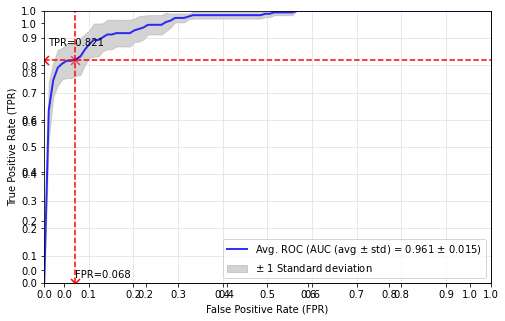


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.961 +/- 0.015
Accuracy (Avg. +/- Std.) is  0.896 +/- 0.032
Avg. CM is [[32, 5], [7, 76]]
Total for all folds CM is [[161, 28], [35, 383]]
Sensitivity (Avg. +/- Std.) is  0.822 +/- 0.054
Specificity (Avg. +/- Std.) is  0.932 +/- 0.048
Precision (Avg. +/- Std.) is  0.861 +/- 0.084
FOR (Avg. +/- Std.) is  0.083 +/- 0.024
DOR (Avg. +/- Std.) is  144.309 +/- 123.520
106:	learn: 0.2346344	total: 261ms	remaining: 471ms
107:	learn: 0.2337291	total: 262ms	remaining: 466ms
108:	learn: 0.2324126	total: 263ms	remaining: 462ms
109:	learn: 0.2318330	total: 265ms	remaining: 457ms
110:	learn: 0.2312072	total: 266ms	remaining: 452ms
111:	learn: 0.2305109	total: 267ms	remaining: 448ms
112:	learn: 0.2297604	total: 275ms	remaining: 456ms
113:	learn: 0.2293294	total: 276ms	remaining: 451ms
114:	learn: 0.2289200	total: 277ms	remaining: 446ms
115:	learn: 0.2285201	total: 278ms	remaining: 441ms
116:	learn: 0.2280006	total: 279ms	rema

64:	learn: 0.2982571	total: 187ms	remaining: 676ms
65:	learn: 0.2964484	total: 189ms	remaining: 671ms
66:	learn: 0.2943619	total: 194ms	remaining: 674ms
67:	learn: 0.2931128	total: 194ms	remaining: 663ms
68:	learn: 0.2918351	total: 202ms	remaining: 675ms
69:	learn: 0.2896212	total: 203ms	remaining: 667ms
70:	learn: 0.2875718	total: 204ms	remaining: 659ms
71:	learn: 0.2860937	total: 205ms	remaining: 650ms
72:	learn: 0.2842406	total: 207ms	remaining: 642ms
73:	learn: 0.2830528	total: 208ms	remaining: 634ms
74:	learn: 0.2816900	total: 214ms	remaining: 643ms
75:	learn: 0.2809930	total: 220ms	remaining: 647ms
76:	learn: 0.2795514	total: 221ms	remaining: 640ms
77:	learn: 0.2786690	total: 222ms	remaining: 632ms
78:	learn: 0.2775976	total: 224ms	remaining: 625ms
79:	learn: 0.2766637	total: 225ms	remaining: 619ms
80:	learn: 0.2755924	total: 226ms	remaining: 612ms
81:	learn: 0.2734328	total: 228ms	remaining: 605ms
82:	learn: 0.2724289	total: 231ms	remaining: 603ms
83:	learn: 0.2699751	total: 233

63:	learn: 0.3072712	total: 160ms	remaining: 591ms
64:	learn: 0.3057954	total: 161ms	remaining: 584ms
65:	learn: 0.3043849	total: 163ms	remaining: 576ms
66:	learn: 0.3033060	total: 170ms	remaining: 592ms
67:	learn: 0.3019680	total: 171ms	remaining: 585ms
68:	learn: 0.3007717	total: 173ms	remaining: 579ms
69:	learn: 0.2987338	total: 175ms	remaining: 574ms
70:	learn: 0.2978554	total: 176ms	remaining: 567ms
71:	learn: 0.2962342	total: 177ms	remaining: 559ms
72:	learn: 0.2951440	total: 178ms	remaining: 552ms
73:	learn: 0.2940823	total: 179ms	remaining: 546ms
74:	learn: 0.2932797	total: 180ms	remaining: 539ms
75:	learn: 0.2920375	total: 181ms	remaining: 532ms
76:	learn: 0.2913248	total: 182ms	remaining: 526ms
77:	learn: 0.2905336	total: 183ms	remaining: 520ms
78:	learn: 0.2891529	total: 184ms	remaining: 513ms
79:	learn: 0.2882501	total: 205ms	remaining: 563ms
80:	learn: 0.2874655	total: 206ms	remaining: 556ms
81:	learn: 0.2865220	total: 207ms	remaining: 550ms
82:	learn: 0.2860125	total: 208

93:	learn: 0.2661354	total: 253ms	remaining: 555ms
94:	learn: 0.2653056	total: 255ms	remaining: 550ms
95:	learn: 0.2647977	total: 271ms	remaining: 575ms
96:	learn: 0.2636126	total: 272ms	remaining: 570ms
97:	learn: 0.2629811	total: 273ms	remaining: 564ms
98:	learn: 0.2624012	total: 274ms	remaining: 557ms
99:	learn: 0.2605687	total: 277ms	remaining: 555ms
100:	learn: 0.2584963	total: 278ms	remaining: 549ms
101:	learn: 0.2577283	total: 280ms	remaining: 544ms
102:	learn: 0.2569483	total: 281ms	remaining: 538ms
103:	learn: 0.2560387	total: 289ms	remaining: 545ms
104:	learn: 0.2553645	total: 295ms	remaining: 548ms
105:	learn: 0.2545597	total: 296ms	remaining: 542ms
106:	learn: 0.2540110	total: 300ms	remaining: 542ms
107:	learn: 0.2536613	total: 304ms	remaining: 541ms
108:	learn: 0.2529710	total: 306ms	remaining: 535ms
109:	learn: 0.2522961	total: 307ms	remaining: 530ms
110:	learn: 0.2517240	total: 308ms	remaining: 525ms
111:	learn: 0.2509798	total: 314ms	remaining: 526ms
112:	learn: 0.25057

In [21]:
i=1
Accuracy = []                                                                
FP = []                                                                     
TN = []                                                                     
FN = []                                                                    
TP = []                                                                     
tprs = []                                                                   
aucs_ens = []                                                                
sn = []                                                                     
sp = []                                                                     
pr = []                                                                      
FOR = []                                                                   
DOR = []                                                                    
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                    

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             

    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')           

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),           
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                             
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                             
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)                          

print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))

### Analyzing XB + LBGM

Learning rate set to 0.022815
0:	learn: 0.6733533	total: 840us	remaining: 251ms
1:	learn: 0.6497345	total: 1.85ms	remaining: 276ms
2:	learn: 0.6301004	total: 2.84ms	remaining: 281ms
3:	learn: 0.6166519	total: 3.77ms	remaining: 279ms
4:	learn: 0.6002938	total: 4.95ms	remaining: 292ms
5:	learn: 0.5863348	total: 6.48ms	remaining: 318ms
6:	learn: 0.5719994	total: 7.48ms	remaining: 313ms
7:	learn: 0.5572250	total: 8.54ms	remaining: 312ms
8:	learn: 0.5426176	total: 9.49ms	remaining: 307ms
9:	learn: 0.5285413	total: 10.4ms	remaining: 302ms
10:	learn: 0.5178562	total: 11.6ms	remaining: 305ms
11:	learn: 0.5046699	total: 12.8ms	remaining: 306ms
12:	learn: 0.4944591	total: 13.7ms	remaining: 303ms
13:	learn: 0.4843256	total: 14.7ms	remaining: 301ms
14:	learn: 0.4767475	total: 15.6ms	remaining: 297ms
15:	learn: 0.4671416	total: 16.6ms	remaining: 295ms
16:	learn: 0.4582784	total: 17.8ms	remaining: 296ms
17:	learn: 0.4508742	total: 19.7ms	remaining: 309ms
18:	learn: 0.4428733	total: 21ms	remaining: 3

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        82
           1       0.83      0.75      0.79        40

    accuracy                           0.87       122
   macro avg       0.86      0.84      0.85       122
weighted avg       0.87      0.87      0.87       122


Area Under ROC (AUC): 0.9469512195121952

Confusion Matrix for current fold: 
[[76  6]
 [10 30]]

Accuracy for Current Fold: 0.8688524590163934

Learning rate set to 0.022815
0:	learn: 0.6753329	total: 774us	remaining: 231ms
1:	learn: 0.6552214	total: 1.71ms	remaining: 255ms
2:	learn: 0.6398769	total: 2.72ms	remaining: 269ms
3:	learn: 0.6267664	total: 3.62ms	remaining: 268ms
4:	learn: 0.6121984	total: 4.54ms	remaining: 268ms
5:	learn: 0.5990959	total: 5.42ms	remaining: 265ms
6:	learn: 0.5864323	total: 6.4ms	remaining: 268ms
7:	learn: 0.5729267	total: 7.37ms	remaini

186:	learn: 0.2238683	total: 169ms	remaining: 102ms
187:	learn: 0.2236706	total: 170ms	remaining: 101ms
188:	learn: 0.2232996	total: 171ms	remaining: 100ms
189:	learn: 0.2230066	total: 172ms	remaining: 99.6ms
190:	learn: 0.2221900	total: 173ms	remaining: 98.7ms
191:	learn: 0.2216382	total: 174ms	remaining: 97.7ms
192:	learn: 0.2203282	total: 175ms	remaining: 96.8ms
193:	learn: 0.2199992	total: 176ms	remaining: 95.9ms
194:	learn: 0.2196026	total: 177ms	remaining: 95ms
195:	learn: 0.2191348	total: 177ms	remaining: 94.2ms
196:	learn: 0.2189652	total: 178ms	remaining: 93.2ms
197:	learn: 0.2187071	total: 179ms	remaining: 92.3ms
198:	learn: 0.2177295	total: 180ms	remaining: 91.4ms
199:	learn: 0.2173663	total: 181ms	remaining: 90.5ms
200:	learn: 0.2172014	total: 182ms	remaining: 89.7ms
201:	learn: 0.2168313	total: 183ms	remaining: 88.9ms
202:	learn: 0.2163957	total: 184ms	remaining: 88ms
203:	learn: 0.2162241	total: 185ms	remaining: 87ms
204:	learn: 0.2155193	total: 186ms	remaining: 86.1ms
20

190:	learn: 0.2056867	total: 170ms	remaining: 96.8ms
191:	learn: 0.2054248	total: 171ms	remaining: 96ms
192:	learn: 0.2051571	total: 172ms	remaining: 95.1ms
193:	learn: 0.2050079	total: 173ms	remaining: 94.3ms
194:	learn: 0.2048241	total: 174ms	remaining: 93.6ms
195:	learn: 0.2044782	total: 175ms	remaining: 92.7ms
196:	learn: 0.2041446	total: 176ms	remaining: 91.9ms
197:	learn: 0.2038270	total: 177ms	remaining: 91ms
198:	learn: 0.2034466	total: 177ms	remaining: 90.1ms
199:	learn: 0.2032392	total: 178ms	remaining: 89.2ms
200:	learn: 0.2023476	total: 179ms	remaining: 88.3ms
201:	learn: 0.2021843	total: 180ms	remaining: 87.4ms
202:	learn: 0.2019938	total: 181ms	remaining: 86.5ms
203:	learn: 0.2016096	total: 182ms	remaining: 85.7ms
204:	learn: 0.2013572	total: 183ms	remaining: 84.8ms
205:	learn: 0.2007036	total: 184ms	remaining: 83.9ms
206:	learn: 0.2004803	total: 185ms	remaining: 83.1ms
207:	learn: 0.2001311	total: 186ms	remaining: 82.3ms
208:	learn: 0.1992088	total: 187ms	remaining: 81.5

85:	learn: 0.2694237	total: 87.4ms	remaining: 218ms
86:	learn: 0.2683633	total: 88.4ms	remaining: 217ms
87:	learn: 0.2665285	total: 89.5ms	remaining: 215ms
88:	learn: 0.2652978	total: 90.5ms	remaining: 214ms
89:	learn: 0.2642145	total: 91.5ms	remaining: 213ms
90:	learn: 0.2638334	total: 92.5ms	remaining: 212ms
91:	learn: 0.2630340	total: 93.5ms	remaining: 211ms
92:	learn: 0.2619143	total: 94.5ms	remaining: 210ms
93:	learn: 0.2611959	total: 95.6ms	remaining: 210ms
94:	learn: 0.2598769	total: 96.7ms	remaining: 209ms
95:	learn: 0.2590399	total: 97.7ms	remaining: 208ms
96:	learn: 0.2576894	total: 98.7ms	remaining: 206ms
97:	learn: 0.2570778	total: 99.7ms	remaining: 205ms
98:	learn: 0.2564089	total: 101ms	remaining: 204ms
99:	learn: 0.2554925	total: 102ms	remaining: 203ms
100:	learn: 0.2547894	total: 103ms	remaining: 202ms
101:	learn: 0.2544948	total: 104ms	remaining: 201ms
102:	learn: 0.2535923	total: 105ms	remaining: 201ms
103:	learn: 0.2529453	total: 106ms	remaining: 200ms
104:	learn: 0.

Learning rate set to 0.022835
0:	learn: 0.6769966	total: 952us	remaining: 285ms
1:	learn: 0.6600906	total: 1.96ms	remaining: 292ms
2:	learn: 0.6409105	total: 2.9ms	remaining: 287ms
3:	learn: 0.6279008	total: 3.81ms	remaining: 282ms
4:	learn: 0.6117773	total: 4.72ms	remaining: 278ms
5:	learn: 0.5975353	total: 5.69ms	remaining: 279ms
6:	learn: 0.5830653	total: 6.63ms	remaining: 278ms
7:	learn: 0.5676079	total: 7.56ms	remaining: 276ms
8:	learn: 0.5534201	total: 8.52ms	remaining: 275ms
9:	learn: 0.5405464	total: 9.42ms	remaining: 273ms
10:	learn: 0.5297640	total: 10.4ms	remaining: 272ms
11:	learn: 0.5186624	total: 11.3ms	remaining: 271ms
12:	learn: 0.5104160	total: 12.2ms	remaining: 270ms
13:	learn: 0.4998074	total: 13.1ms	remaining: 268ms
14:	learn: 0.4909457	total: 14.1ms	remaining: 269ms
15:	learn: 0.4809904	total: 15.1ms	remaining: 268ms
16:	learn: 0.4728339	total: 16ms	remaining: 267ms
17:	learn: 0.4656253	total: 17ms	remaining: 266ms
18:	learn: 0.4582443	total: 17.9ms	remaining: 265m

183:	learn: 0.2048776	total: 166ms	remaining: 105ms
184:	learn: 0.2041148	total: 168ms	remaining: 104ms
185:	learn: 0.2034245	total: 169ms	remaining: 103ms
186:	learn: 0.2033103	total: 170ms	remaining: 103ms
187:	learn: 0.2031084	total: 171ms	remaining: 102ms
188:	learn: 0.2015986	total: 172ms	remaining: 101ms
189:	learn: 0.2012554	total: 173ms	remaining: 100ms
190:	learn: 0.2009723	total: 174ms	remaining: 99.3ms
191:	learn: 0.2006512	total: 175ms	remaining: 98.4ms
192:	learn: 0.2003258	total: 176ms	remaining: 97.5ms
193:	learn: 0.1998362	total: 177ms	remaining: 96.6ms
194:	learn: 0.1995869	total: 178ms	remaining: 95.7ms
195:	learn: 0.1993690	total: 179ms	remaining: 94.8ms
196:	learn: 0.1991783	total: 180ms	remaining: 93.9ms
197:	learn: 0.1985541	total: 180ms	remaining: 93ms
198:	learn: 0.1982191	total: 181ms	remaining: 92ms
199:	learn: 0.1978964	total: 182ms	remaining: 91.2ms
200:	learn: 0.1976976	total: 183ms	remaining: 90.3ms
201:	learn: 0.1971969	total: 184ms	remaining: 89.4ms
202:

203:	learn: 0.2050565	total: 150ms	remaining: 70.5ms
204:	learn: 0.2047205	total: 150ms	remaining: 69.7ms
205:	learn: 0.2044579	total: 151ms	remaining: 69ms
206:	learn: 0.2036799	total: 152ms	remaining: 68.3ms
207:	learn: 0.2030803	total: 153ms	remaining: 67.6ms
208:	learn: 0.2028610	total: 153ms	remaining: 66.8ms
209:	learn: 0.2025791	total: 154ms	remaining: 66ms
210:	learn: 0.2023726	total: 155ms	remaining: 65.3ms
211:	learn: 0.2021584	total: 155ms	remaining: 64.5ms
212:	learn: 0.2016898	total: 156ms	remaining: 63.7ms
213:	learn: 0.2010818	total: 157ms	remaining: 62.9ms
214:	learn: 0.2000036	total: 157ms	remaining: 62.2ms
215:	learn: 0.1993662	total: 158ms	remaining: 61.4ms
216:	learn: 0.1987721	total: 159ms	remaining: 60.6ms
217:	learn: 0.1986173	total: 159ms	remaining: 59.9ms
218:	learn: 0.1981492	total: 160ms	remaining: 59.1ms
219:	learn: 0.1977924	total: 160ms	remaining: 58.4ms
220:	learn: 0.1975982	total: 161ms	remaining: 57.6ms
221:	learn: 0.1971654	total: 162ms	remaining: 56.8

107:	learn: 0.2498342	total: 116ms	remaining: 206ms
108:	learn: 0.2480623	total: 117ms	remaining: 205ms
109:	learn: 0.2474672	total: 118ms	remaining: 203ms
110:	learn: 0.2470005	total: 120ms	remaining: 204ms
111:	learn: 0.2466734	total: 121ms	remaining: 204ms
112:	learn: 0.2460160	total: 122ms	remaining: 202ms
113:	learn: 0.2456356	total: 123ms	remaining: 201ms
114:	learn: 0.2452155	total: 124ms	remaining: 200ms
115:	learn: 0.2444189	total: 125ms	remaining: 198ms
116:	learn: 0.2436913	total: 126ms	remaining: 197ms
117:	learn: 0.2428305	total: 127ms	remaining: 196ms
118:	learn: 0.2422883	total: 128ms	remaining: 195ms
119:	learn: 0.2419759	total: 129ms	remaining: 194ms
120:	learn: 0.2414800	total: 131ms	remaining: 194ms
121:	learn: 0.2411052	total: 133ms	remaining: 193ms
122:	learn: 0.2405062	total: 134ms	remaining: 193ms
123:	learn: 0.2400006	total: 135ms	remaining: 192ms
124:	learn: 0.2396487	total: 136ms	remaining: 190ms
125:	learn: 0.2392869	total: 137ms	remaining: 189ms
126:	learn: 

274:	learn: 0.1791434	total: 286ms	remaining: 26ms
275:	learn: 0.1787519	total: 287ms	remaining: 25ms
276:	learn: 0.1781442	total: 288ms	remaining: 23.9ms
277:	learn: 0.1779108	total: 289ms	remaining: 22.9ms
278:	learn: 0.1778025	total: 290ms	remaining: 21.8ms
279:	learn: 0.1776220	total: 291ms	remaining: 20.8ms
280:	learn: 0.1772300	total: 292ms	remaining: 19.7ms
281:	learn: 0.1765761	total: 292ms	remaining: 18.7ms
282:	learn: 0.1763475	total: 293ms	remaining: 17.6ms
283:	learn: 0.1759221	total: 294ms	remaining: 16.6ms
284:	learn: 0.1758419	total: 295ms	remaining: 15.5ms
285:	learn: 0.1753076	total: 296ms	remaining: 14.5ms
286:	learn: 0.1750315	total: 296ms	remaining: 13.4ms
287:	learn: 0.1747998	total: 297ms	remaining: 12.4ms
288:	learn: 0.1746750	total: 298ms	remaining: 11.3ms
289:	learn: 0.1745542	total: 299ms	remaining: 10.3ms
290:	learn: 0.1741692	total: 300ms	remaining: 9.27ms
291:	learn: 0.1738886	total: 301ms	remaining: 8.24ms
292:	learn: 0.1737021	total: 302ms	remaining: 7.21

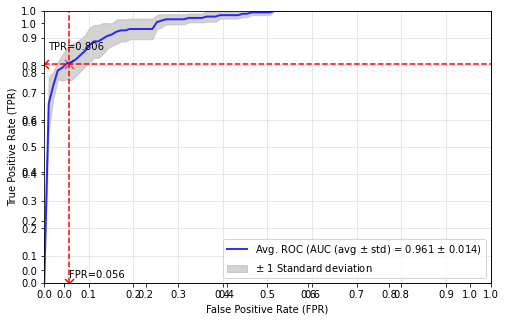


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.961 +/- 0.014
Accuracy (Avg. +/- Std.) is  0.899 +/- 0.022
Avg. CM is [[31, 4], [7, 77]]
Total for all folds CM is [[158, 23], [38, 388]]
Sensitivity (Avg. +/- Std.) is  0.806 +/- 0.069
Specificity (Avg. +/- Std.) is  0.944 +/- 0.027
Precision (Avg. +/- Std.) is  0.878 +/- 0.055
FOR (Avg. +/- Std.) is  0.088 +/- 0.029
DOR (Avg. +/- Std.) is  113.670 +/- 68.456


In [22]:
from sklearn.ensemble import VotingClassifier
i=2
Accuracy = []                                                               
FP = []                                                                      
TN = []                                                                     
FN = []                                                                     
TP = []                                                                     
tprs = []                                                                   
aucs_ens = []                                                               
sn = []                                                                      
sp = []                                                                      
pr = []                                                                     
FOR = []                                                                     
DOR = []                                                                     
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))



for train_index, test_index in kf.split(X_Data,Y_Lavel):                    

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]            


    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')           

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),           
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                            
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                            
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)                          

print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))

